# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [5]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline


from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [8]:
data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# how many samples per batch to load
batch_size = 20
num_workers=0
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
print(train_sampler)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  4996
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
Image resizing: for the training (and validation set of course) images are resized and cropped to 224 by 224 pixels. I chose this size because it is equal to the input size of all pretrained networks (except inception-v3) to have the same basis of comparison when I try in the next step to use transfer learning and observe the performance. Also, landmark images have a lot of details like textures, nature elements and edges. I believe that using smaller image sizes like 50 by 50 or even 100 by 100 might compress a lot of useful spatial imformation that we need to increase the classification accuracy

Dataset augmentation: I used data augmentation of random cropping, horizontal fliplig and slight random rotation 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

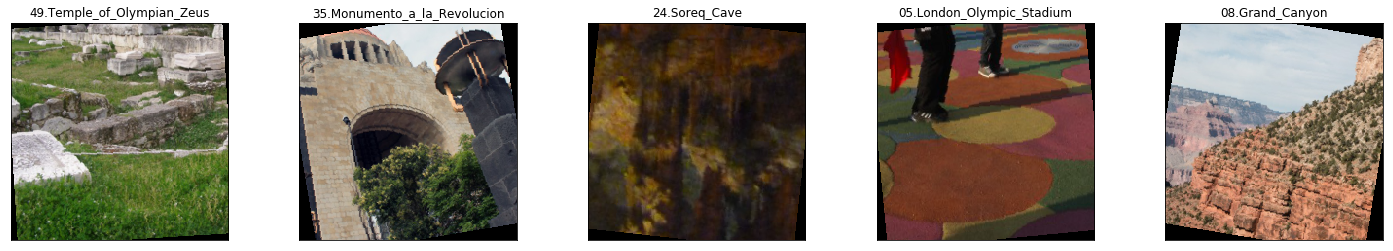

In [9]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
#print(train_data.classes)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    #print(images[idx][:5,:])
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_data.classes[labels[idx]])

### Initialize use_cuda variable

In [10]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [11]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [ ]:
# First trial (Unsuccessful, didn't train well)
#import torch.nn as nn
#import torch.nn.functional as F

# define the CNN architecture
#class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
#    def __init__(self, constant_weight=None):
#        super(Net, self).__init__()
        
#        ## Define layers of a CNN
#        # convolutional layer (sees 224x224x3 image tensor)
#        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        # convolutional layer (sees 112x112x64 tensor)
#        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        # convolutional layer (sees 56x56x64 tensor)
#        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)        
        # convolutional layer (sees 28x28x128 image tensor)
#        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # convolutional layer (sees 14x14x256 tensor)
#        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        
        # max pooling layer
#        self.pool = nn.MaxPool2d(2, 2)
        
        
        # linear layer (512 * 7 * 7 -> 1024)
#        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        # linear layer (1024 -> 512)
#        self.fc2 = nn.Linear(1024, 512)
        # linear layer (512 -> 50)
#        self.fc3 = nn.Linear(512, 50)
        # dropout layer (p=0.25)
#        self.dropout = nn.Dropout(0.25)

        # initialize the weights to a specified, constant value
#        if(constant_weight is not None):
#            for m in self.modules():
#                if isinstance(m, nn.Linear):
#                    nn.init.constant_(m.weight, constant_weight)
#                    nn.init.constant_(m.bias, 0)
        
    
#    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
#        x = self.pool(F.relu(self.conv1(x)))
#        x = self.pool(F.relu(self.conv2(x)))
#        x = self.pool(F.relu(self.conv3(x)))
#        x = self.pool(F.relu(self.conv4(x)))
#        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
#        x = x.view(-1, 512 * 7 * 7)
        # add dropout layer
#        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
#        x = F.relu(self.fc1(x))
        # add dropout layer
#        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
#        x = F.relu(self.fc2(x))
        # add dropout layer
#        x = self.dropout(x)
        # add 3rd hidden layer, with relu activation function
#        x = self.fc3(x)
        
#        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
#model_scratch = Net()
#print(model_scratch)

# move tensors to GPU if CUDA is available
#if use_cuda:
#    model_scratch.cuda()

In [12]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, constant_weight=None):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)      
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 50)
        self.fc2 = nn.Linear(500, 50)


        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)

        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
As advised in the course, I first searched for similar work done for detecting landmarks and I found a nice paper comparing different architectures to achieve this task here https://www.ijitee.org/wp-content/uploads/papers/v10i7/G89830510721.pdf

In their results they concluded that ResNet-50 is the best performing model. I tried to mimic the structure a little bit but with 1 conv layer in each stack so my networks had only 5 instead of 48 convolution layers. I only used maxpooling (instead of combining max and average pooling in ResNet -50). ResNet has 2 final fully connected layers, but I added one more (hoping to compensate the very limited number of conv. layers).

I used custom normal weight initialization but unfortunately this structure was very deep so the grads vanished so quickly and I got training loss = validation loss = 0.000783 for almost all the training epochs so I decided to make a smaller structure like the one described in the course videos with 3 convolutional layers and 2 fully connected layers

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    #print(save_path)
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))  
    
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [14]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    


In [12]:
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 0.000783 	Validation Loss: 0.000783
Validation loss decreased (inf --> 0.000783).  Saving model ...
Epoch: 2 	Training Loss: 0.000781 	Validation Loss: 0.000780
Validation loss decreased (0.000783 --> 0.000780).  Saving model ...
Epoch: 3 	Training Loss: 0.000774 	Validation Loss: 0.000769
Validation loss decreased (0.000780 --> 0.000769).  Saving model ...
Epoch: 4 	Training Loss: 0.000762 	Validation Loss: 0.000760
Validation loss decreased (0.000769 --> 0.000760).  Saving model ...
Epoch: 5 	Training Loss: 0.000755 	Validation Loss: 0.000752
Validation loss decreased (0.000760 --> 0.000752).  Saving model ...
Epoch: 6 	Training Loss: 0.000748 	Validation Loss: 0.000747
Validation loss decreased (0.000752 --> 0.000747).  Saving model ...
Epoch: 7 	Training Loss: 0.000740 	Validation Loss: 0.000745
Validation loss decreased (0.000747 --> 0.000745).  Saving model ...
Epoch: 8 	Training Loss: 0.000734 	Validation Loss: 0.000731
Validation loss decreased (0.00074

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [15]:
#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()


In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000783 	Validation Loss: 0.000783
Validation loss decreased (inf --> 0.000783).  Saving model ...
Epoch: 2 	Training Loss: 0.000782 	Validation Loss: 0.000782
Validation loss decreased (0.000783 --> 0.000782).  Saving model ...
Epoch: 3 	Training Loss: 0.000781 	Validation Loss: 0.000780
Validation loss decreased (0.000782 --> 0.000780).  Saving model ...
Epoch: 4 	Training Loss: 0.000777 	Validation Loss: 0.000774
Validation loss decreased (0.000780 --> 0.000774).  Saving model ...
Epoch: 5 	Training Loss: 0.000769 	Validation Loss: 0.000764
Validation loss decreased (0.000774 --> 0.000764).  Saving model ...
Epoch: 6 	Training Loss: 0.000758 	Validation Loss: 0.000749
Validation loss decreased (0.000764 --> 0.000749).  Saving model ...
Epoch: 7 	Training Loss: 0.000752 	Validation Loss: 0.000749
Validation loss decreased (0.000749 --> 0.000749).  Saving model ...
Epoch: 8 	Training Loss: 0.000749 	Validation Loss: 0.000740
Validation loss decreased (0.00074

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [14]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.299584


Test Accuracy: 44% (554/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [17]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# how many samples per batch to load
batch_size = 20
num_workers=0
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std = [ 0.229, 0.224, 0.225 ])

    ])

test_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std = [ 0.229, 0.224, 0.225 ])
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [18]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001) #vgg model
    #optimizer = optim.SGD(model.fc.parameters(), lr=0.01)  #resnet model
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [21]:
## TODO: Specify model architecture
model_transfer = models.vgg16(pretrained=True)
# print out the model structure
print(model_transfer)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(train_data.classes))
model_transfer.classifier[6] = last_layer
print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [24]:
#from torchvision import models

#model_transfer = models.resnet50(pretrained=True)
# print out the model structure
#print(model_transfer)

# Freeze training for all "features" layers
#for param in model_transfer.parameters():
#    param.requires_grad = False
    
#n_inputs = model_transfer.fc.in_features
#last_layer = nn.Linear(n_inputs, len(train_data.classes))
#model_transfer.fc = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

#if use_cuda:
#    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
First I used the same data augmentation used by the scratch model (random rotation, cropping, flipping). I tried vgg16 and it wasn't learning well even when trying Adam instead of SGD and even by rasing the learning rate from 0.01 to 0.1

I thought of changing the structure to resnet 50 which according to the paper I found was giving the best performance for landmark detection. I used adam and sgd, learning rate has been decreased to 0.001 because the error was fluctuating but didn't achieve much better performance.

Finally I decided to go back to the vgg16 model but added the image normalization to the dataloader component. I used the normalization parameters advised for pre-trained vgg16 mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ] so finally the training went well and the test accuracy was 78%

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
#model_transfer.apply(default_weight_init)
model_transfer = train(100, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.000750 	Validation Loss: 0.000682
Validation loss decreased (inf --> 0.000682).  Saving model ...
Epoch: 2 	Training Loss: 0.000640 	Validation Loss: 0.000579
Validation loss decreased (0.000682 --> 0.000579).  Saving model ...
Epoch: 3 	Training Loss: 0.000544 	Validation Loss: 0.000492
Validation loss decreased (0.000579 --> 0.000492).  Saving model ...
Epoch: 4 	Training Loss: 0.000475 	Validation Loss: 0.000430
Validation loss decreased (0.000492 --> 0.000430).  Saving model ...
Epoch: 5 	Training Loss: 0.000419 	Validation Loss: 0.000392
Validation loss decreased (0.000430 --> 0.000392).  Saving model ...
Epoch: 6 	Training Loss: 0.000398 	Validation Loss: 0.000358
Validation loss decreased (0.000392 --> 0.000358).  Saving model ...
Epoch: 7 	Training Loss: 0.000371 	Validation Loss: 0.000334
Validation loss decreased (0.000358 --> 0.000334).  Saving model ...
Epoch: 8 	Training Loss: 0.000357 	Validation Loss: 0.000327
Validation loss decreased (0.00033

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.779844


Test Accuracy: 78% (984/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [35]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # Load the best model
    #model_transfer = models.vgg16(pretrained=True)
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
        
    model_transfer.cuda()
    # set the module to evaluation mode
    model_transfer.eval()

    # Read PIL image 
    input_image=Image.open(img_path)
    r, g, b = input_image.split()
    
    # Normalize to Vgg16 input values mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ])
    r = r.point(lambda i: (i-0.485)/0.229)
    g = g.point(lambda i: (i-0.456)/0.224)
    b = b.point(lambda i: (i-0.406)/0.225)

    # Recombine back to RGB image
    norm_img = Image.merge('RGB', (r, g, b))
        
    # Convert to numpy array
    input_image= np.array(norm_img)
    #input_image= np.array(input_image)
    #print(input_image.shape)
    
    Resized = cv2.resize(input_image,(250,250))
    cropped_image = Resized[13:237, 13:237]

    #print(cropped_image.shape)
    
    # Convert to tensor
    input_image2= torch.from_numpy(cropped_image.transpose(2,0,1))    
    input_image2 = torch.unsqueeze(input_image2, 0)
    #print(input_image2.shape)
    
    if torch.cuda.is_available():# move to image to GPU 
        input_image3 = input_image2.to(device='cuda', dtype=torch.float)  #input_image2.cuda()
            
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_transfer(input_image3)
    
    # move output tensor to cpu
    output = output.cpu()
    
    # convert output probabilities to predicted class
    _, pred_list = torch.topk(output.data, k, dim=1)
    pred_list = pred_list.numpy()
    #print(pred_list)
    #print(type(pred_list))
    pred_classes = []
    for c in pred_list[0]:
        pred_classes.append(train_data.classes[c])
            
    return pred_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)


['49.Temple_of_Olympian_Zeus',
 '41.Machu_Picchu',
 '00.Haleakala_National_Park',
 '17.Changdeokgung',
 '12.Kantanagar_Temple']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

['49.Temple_of_Olympian_Zeus', '41.Machu_Picchu', '00.Haleakala_National_Park']
Is this the picture of the 
 Temple_of_Olympian_Zeus, Machu_Picchu, or Haleakala_National_Park?


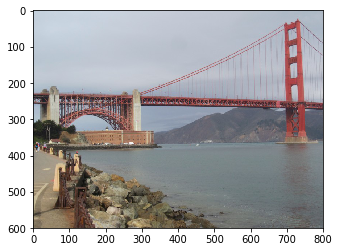

In [36]:
import cv2
from PIL import Image

def suggest_locations(img_path):
    
    # get landmark predictions
    predicted = predict_landmarks(img_path, 3)
    print(predicted)
    
    # Read PIL image 
    input_image=Image.open(img_path)
    input_image= np.array(input_image)
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(input_image)
    
    print("Is this the picture of the \n {}, {}, or {}?".format(predicted[0][3:],predicted[1][3:],predicted[2][3:]))
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The first image was for a bridge between two towers which is very similar to the top-1 choice (although wrong name of the location of course) 

The second image was for a temple not very similar to the top-1 choice, which is also a temple of different structure (but the model predicted a temple after all) 

The third image was for a temple different from the top-1 choice, which is also a temple of different structure (but the model predicted a temple after all) 

The fourth image was for a tower misclassified to temples and castle
So 3 out of 4 images has correct prediction to the content category (regardless the exact location) i.e. 75% correctness supporting the test results of the trained model

Points of improvements:
1- Increase the dataset of images (training and test)
2- Change the classes to the main categories of (temple, tower, bridge, park, etc.) and use the current vgg as category classifier
3- Create ensemble of similar structure vggs each trained on images of 1 category and predict location/name of the site in the image. The "suggest_locations algorithm" shall pass the input image to the matching category vgg based on the category classifier top-1 output

['29.Petronas_Towers', '19.Vienna_City_Hall', '17.Changdeokgung']
Is this the picture of the 
 Petronas_Towers, Vienna_City_Hall, or Changdeokgung?


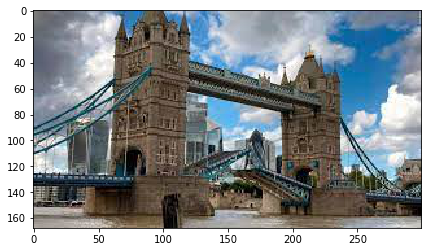

In [37]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('bridge.jpg')

['17.Changdeokgung', '45.Temple_of_Heaven', '29.Petronas_Towers']
Is this the picture of the 
 Changdeokgung, Temple_of_Heaven, or Petronas_Towers?


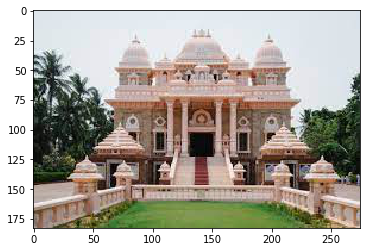

In [38]:
suggest_locations('temple1.jpg')

['49.Temple_of_Olympian_Zeus', '16.Eiffel_Tower', '00.Haleakala_National_Park']
Is this the picture of the 
 Temple_of_Olympian_Zeus, Eiffel_Tower, or Haleakala_National_Park?


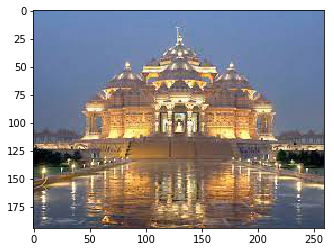

In [39]:
suggest_locations('temple2.jpg')

['17.Changdeokgung', '49.Temple_of_Olympian_Zeus', '10.Edinburgh_Castle']
Is this the picture of the 
 Changdeokgung, Temple_of_Olympian_Zeus, or Edinburgh_Castle?


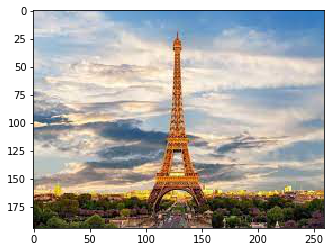

In [40]:
suggest_locations('tower.jpg')